 # 0.0 IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns

from scipy import stats
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from IPython.display import Image
import matplotlib.gridspec as gridspec 
from tabulate import tabulate

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
 
    chi2 = ss.chi2_contingency( cm )[O]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
 
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
 
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ) 


def jupyter_settings():
    %matplotlib inline
    %pylab inline 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
 
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
 
    sns.set() 


## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv ('Data/train.csv' , delimiter= ',' , low_memory=False)
df_store_raw = pd.read_csv ('Data/store.csv' , delimiter= ',', low_memory=False)

# merge
df_raw = pd.merge ( df_sales_raw, df_store_raw, how = 'left', on='Store')

In [4]:
 df_raw.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
472957,983,7,2014-05-04,0,0,0,0,0,0,a,a,40.0,3.0,2014.0,1,1.0,2014.0,"Jan,Apr,Jul,Oct"
1009751,347,1,2013-01-07,5545,405,1,1,0,0,d,c,9360.0,7.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
455473,224,1,2014-05-19,7750,551,1,1,0,0,d,c,7930.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
812068,19,3,2013-07-03,6649,634,1,1,0,0,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
830818,929,1,2013-06-17,7217,896,1,1,0,0,a,c,4820.0,9.0,2013.0,0,NaN,NaN,NaN
65201,532,3,2015-06-03,14162,1624,1,1,0,0,a,c,1070.0,8.0,2010.0,0,NaN,NaN,NaN
140622,133,5,2015-03-27,5893,670,1,0,0,0,a,a,270.0,8.0,2013.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
671254,810,4,2013-11-07,6361,492,1,1,0,0,d,c,9640.0,11.0,2013.0,0,NaN,NaN,NaN
394212,901,3,2014-07-16,7435,646,1,1,0,1,a,c,3170.0,4.0,2014.0,0,NaN,NaN,NaN
945116,382,3,2013-03-06,7387,605,1,1,0,0,c,c,26130.0,11.0,2002.0,0,NaN,NaN,NaN


# 1.0. Passo 01 - DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
        'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore ( x)

cols_new = list (map(snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print ('Number of rows:{}'.format( df1.shape[0]))
print ('Number of columns:{}'.format( df1.shape[1]))

Number of rows:1017209
Number of columns:18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5. Fillout NA

In [10]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

#competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  508031
month_map = {1:'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}

df1['promo_interval'].fillna (0, inplace=True)

df1['month_map'] = df1 ['date'].dt.month.map (month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x ['promo_interval'] == 0 else 1 if x ['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.sample(5).T

,856843,815150,627482,488791,156790
store,194,871,523,92,691
day_of_week,5,1,1,6,5
date,2013-05-24 00:00:00,2013-07-01 00:00:00,2013-12-16 00:00:00,2014-04-19 00:00:00,2015-03-13 00:00:00
sales,4075,7036,25077,5805,7734
customers,381,495,2546,623,566
open,1,1,1,1,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,d,d,c,c,d


# 1.6. Changes Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

# 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int32','int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int32','int64','float64','datetime64[ns]'])

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply (min) ).T
d3 = pd.DataFrame(num_attributes.apply (max) ).T
d4 = pd.DataFrame(num_attributes.apply (lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply (lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply (lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
             

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


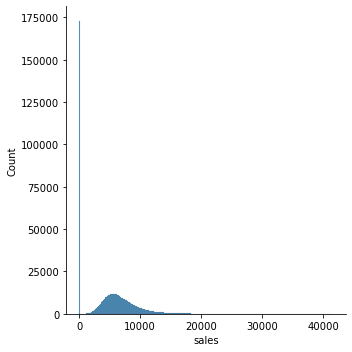

In [17]:
sns.displot(df1['sales'])

## 1.7.2. Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

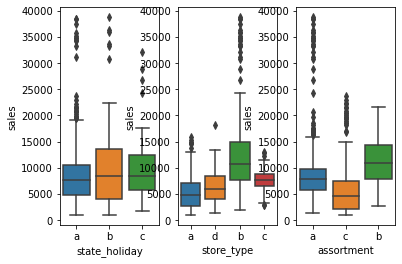

In [19]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday',y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type',y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment',y='sales', data=aux1)

# 2.0. Passo 02 - FEATURE ENGINNEERING 

In [20]:
df2 = df1.copy()

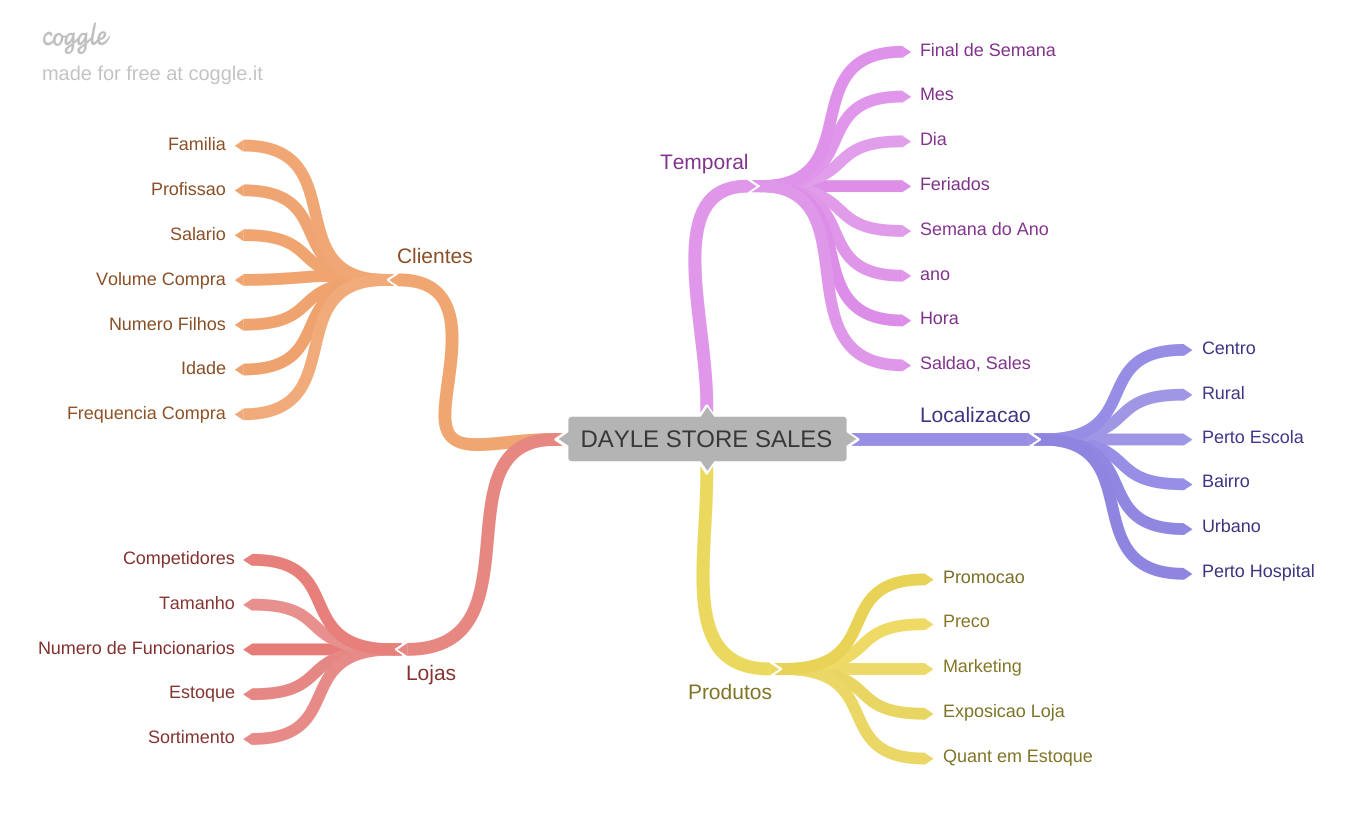

In [21]:
Image ('Image/MindMapHypothesis.png')

## 2.1. Criação das Hipóteses

### 2.2.1. Hipóteses dos Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais. 

### 2.2.3. Hipóteses do Loja 

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipóteses do Tempo ( Sazonalidade ) 

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares. 

## 2.2. Lista Final de Hipóteses 

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais. 

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais. 

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares. 

## 2.3. Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# compentition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2 ['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta ( days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days ).astype (int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x =='c' else 'regular_day')



In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Passo 03 - FILTRAGEM DE VARIAVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [55]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

KeyError: 'open'

## 3.2. Selecao das Colunas 

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Passo 04 - ANALISE EXPLORATORIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

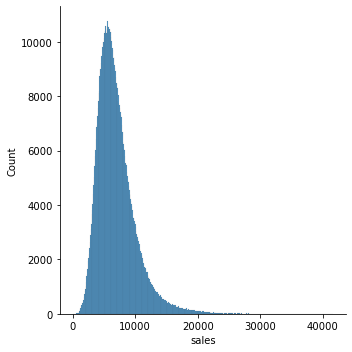

In [30]:
sns.displot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

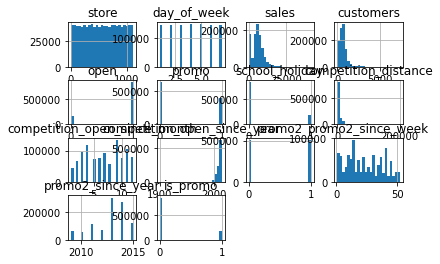

In [31]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

In [32]:
df4 ['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\Tiago Solon\.conda\envs\DS_Rossmann_Store_Sales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tiago Solon\.conda\envs\DS_Rossmann_Store_Sales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tiago Solon\.conda\envs\DS_Rossmann_Store_Sales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:xlabel='sales', ylabel='Density'>

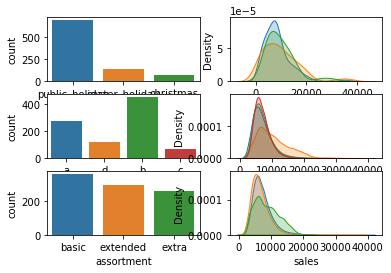

In [33]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']== 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']== 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']== 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']== 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']== 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']== 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']== 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment']== 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']== 'extra']['sales'], label='extra', shade=True)


## 4.2. Analise Bivariada 

#### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vedem MENOS.

<AxesSubplot:xlabel='year_week'>

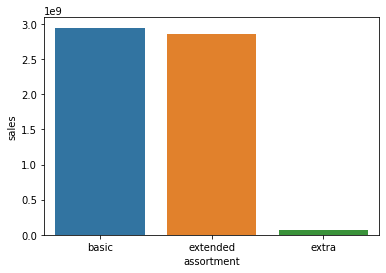

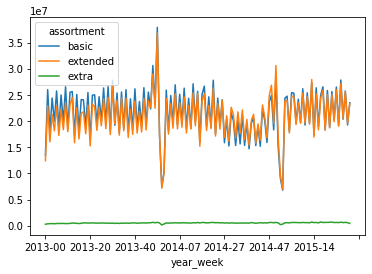

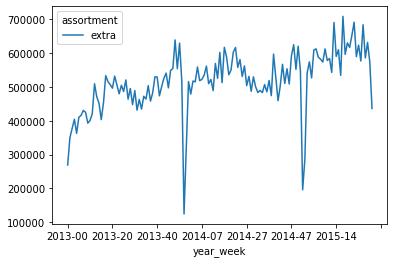

In [34]:
auxl = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=auxl ); 

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot() 

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot() 


#### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSE** lojas com COMPETIDORES MAIS PROXIMOS vedem MAIS.

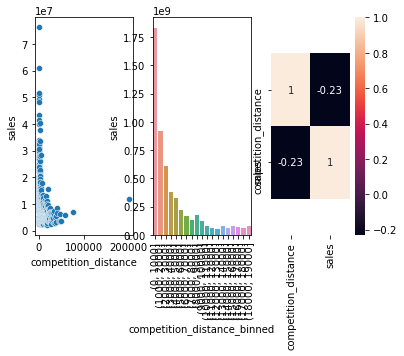

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index() 

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );
 
plt.subplot( 1, 3, 2 ) 
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 ); 

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 ); 


#### H3. Lojas com competidores à mais tempo deveriam vendem mais. 
**FALSA** Lojas com COMPETIDORES a mais tempo vedem MENOS.

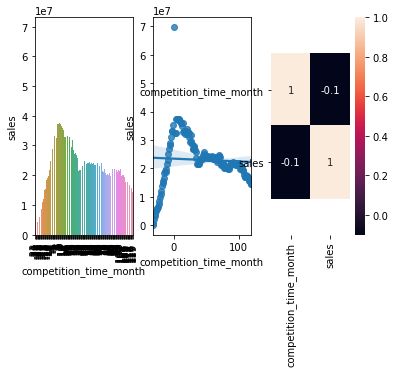

In [36]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby ('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & ( aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim (bottom+0.5, top-0.5);

#### H4. Lojas corn promocetes ativas por mais tempo deveriam vender mais. 
**FALSA** Loias com promocoes ativas por mas tempo vendem menos, depois de um certo periodo de promocao 

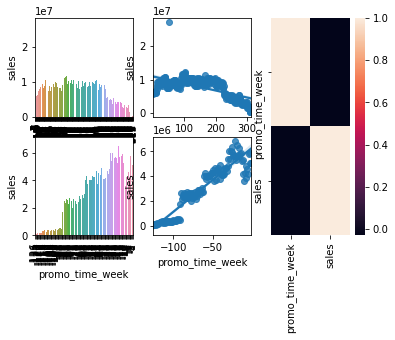

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index() 

grid = gridspec.GridSpec(2,3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid [:,2] )
sns.heatmap( aux1.corr( method='pearson' ) ); 


#### <s> H5. Lojas com mais dias de promocao deveriam vender mais.</s>

#### H7. Lojas com mais pormocoes consecutivas deveriam vender mais.
**FALSE** Lojas com mais promocoes consecutivas vedem menos.

In [38]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


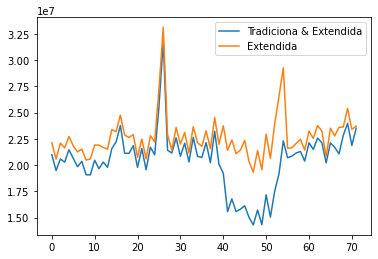

In [39]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1 )] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1) & (df4['promo2'] == 0 )] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradiciona & Extendida', 'Extendida']);


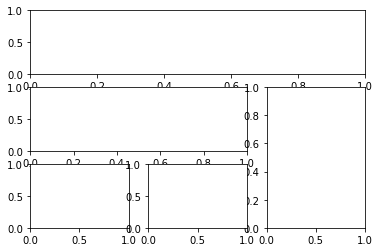

In [40]:
 import matplotlib.gridspec as gridspec  
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1, 0])
ax5 = plt.subplot(gs[-1, -2])

####  **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante feriado de Natal vedem menos.

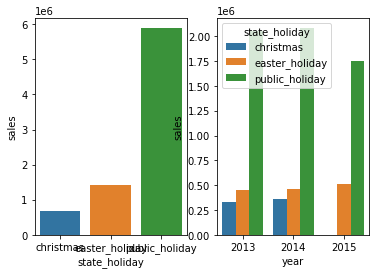

In [41]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 ); 


####  **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vedem menos ao longo dos anos.

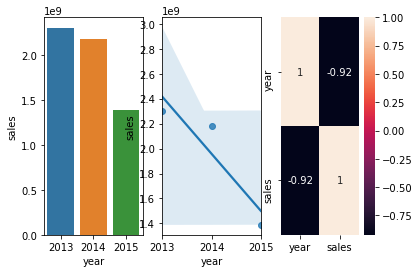

In [42]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 


####  **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vedem menos no segundo semestre do ano.

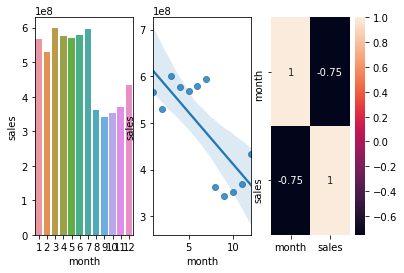

In [43]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 


####  **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vedem mais depois do dia 10 cada mes.

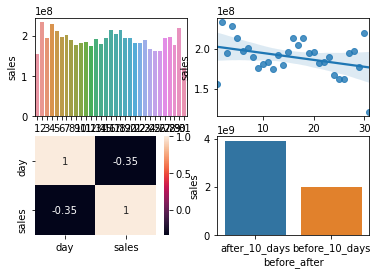

In [44]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 ); 


####  **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vedem menos no final de semana.

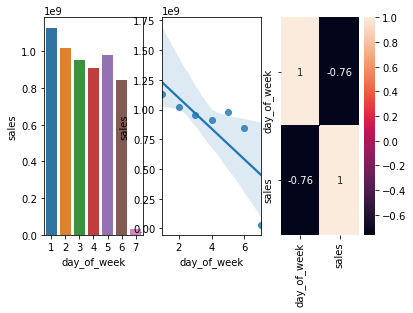

In [45]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); 

####  **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** lojas vedem menosdurante os feriados escolares, exceto os meses de Julio e Agosto.

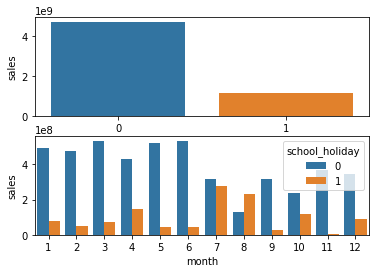

In [46]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 ); 


### 4.2.1. Resumo das H ipoteses 

In [47]:

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '_' , '_',],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'], 
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )  

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           _            _
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada 

### 4.3.1. Numerical Attribuites

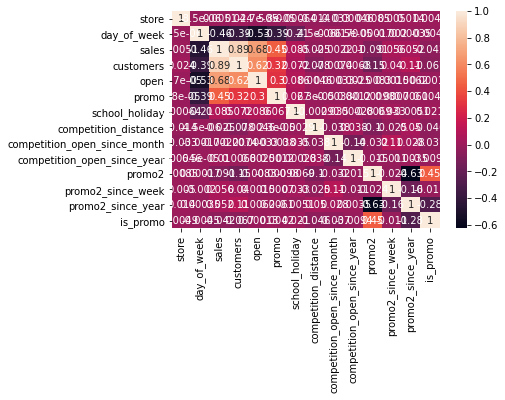

In [48]:
correlation = num_attributes.corr( method ='pearson')
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes 

In [49]:
from scipy import stats as ss

In [50]:
a = df4.select_dtypes( include='object' )

In [51]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [52]:
cm = pd.crosstab( a ['state_holiday'], a['store_type'] ).as_matrix()

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [ ]:
chi2 = ss.chi2_contingency( cm ) [0]

n = cm.sum()

r, k = cm.shape


In [ ]:
chi2

In [ ]:
v = np.sqrt ((chi2/n) / (min( k-1, r-1 ) ) )

In [ ]:
a[(a['state_holiday'] == 'christmas' ) & (a['store_type'] =='a')]

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
 
# Calculate cramer V
a1 = cramer_v( a['state_holiday' ], a['state_holiday'] )
a2 = cramer_v( a['state_holiday' ], a['store_type'] ) 
a3 = cramer_v( a['state_holiday' ], a['assortment'] ) 

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] ) 

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] ) 

# Final dataset
d = pd.DataFrame( {'state_holiday': [al, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns ) 

sns.heatmap( d, annot=True ) 

# 1.1.